## Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below
1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    First, load the dataset from the weatherinszeged table from Thinkful's database.
    Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
    Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.
2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    Load the houseprices data from Thinkful's database.
    Reimplement the model you built in the previous checkpoint.
    Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
    be sure to close the database connection after initially pulling in your data.



## Part 2: House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Reimplement the model you built in the previous checkpoint.
3. Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [ ]:
houseprices_df.head()

In [ ]:
houseprices_df.info()

In [ ]:
houseprices_df.describe()

In [ ]:
total_missing = houseprices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
plt.hist(houseprices_df.saleprice)
plt.title('The distribution of house sale price')
plt.xlabel('sale price')
plt.ylabel('number of occurrence')
plt.show()

##### Looking at numeric features first

In [3]:
numerics_df = houseprices_df.select_dtypes(include=[np.number])
numerics_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
numerics_df.info()

In [4]:
#look at correlation of each potential numeric feature with target
np.abs(numerics_df.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Choosing only variables with corr >0.5
overallqual     0.791
grlivarea       0.709
garagecars      0.640
garagearea      0.623
totalbsmtsf     0.614
firstflrsf      0.606
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507

In [5]:
#potential features from numeric columns: 
num_features = ['overallqual', 'grlivarea', 'garagecars', 
                'garagearea', 'totalbsmtsf', 'firstflrsf', 
                'fullbath', 'totrmsabvgrd', 'yearbuilt',
                'yearremodadd']

In [ ]:
houseprices_df[num_features].isnull().sum()

##### Looking at non-numeric variables

In [6]:
objects_df = houseprices_df.select_dtypes(include=[np.object])
objects_df.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [ ]:
objects_df.info()

In [7]:
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


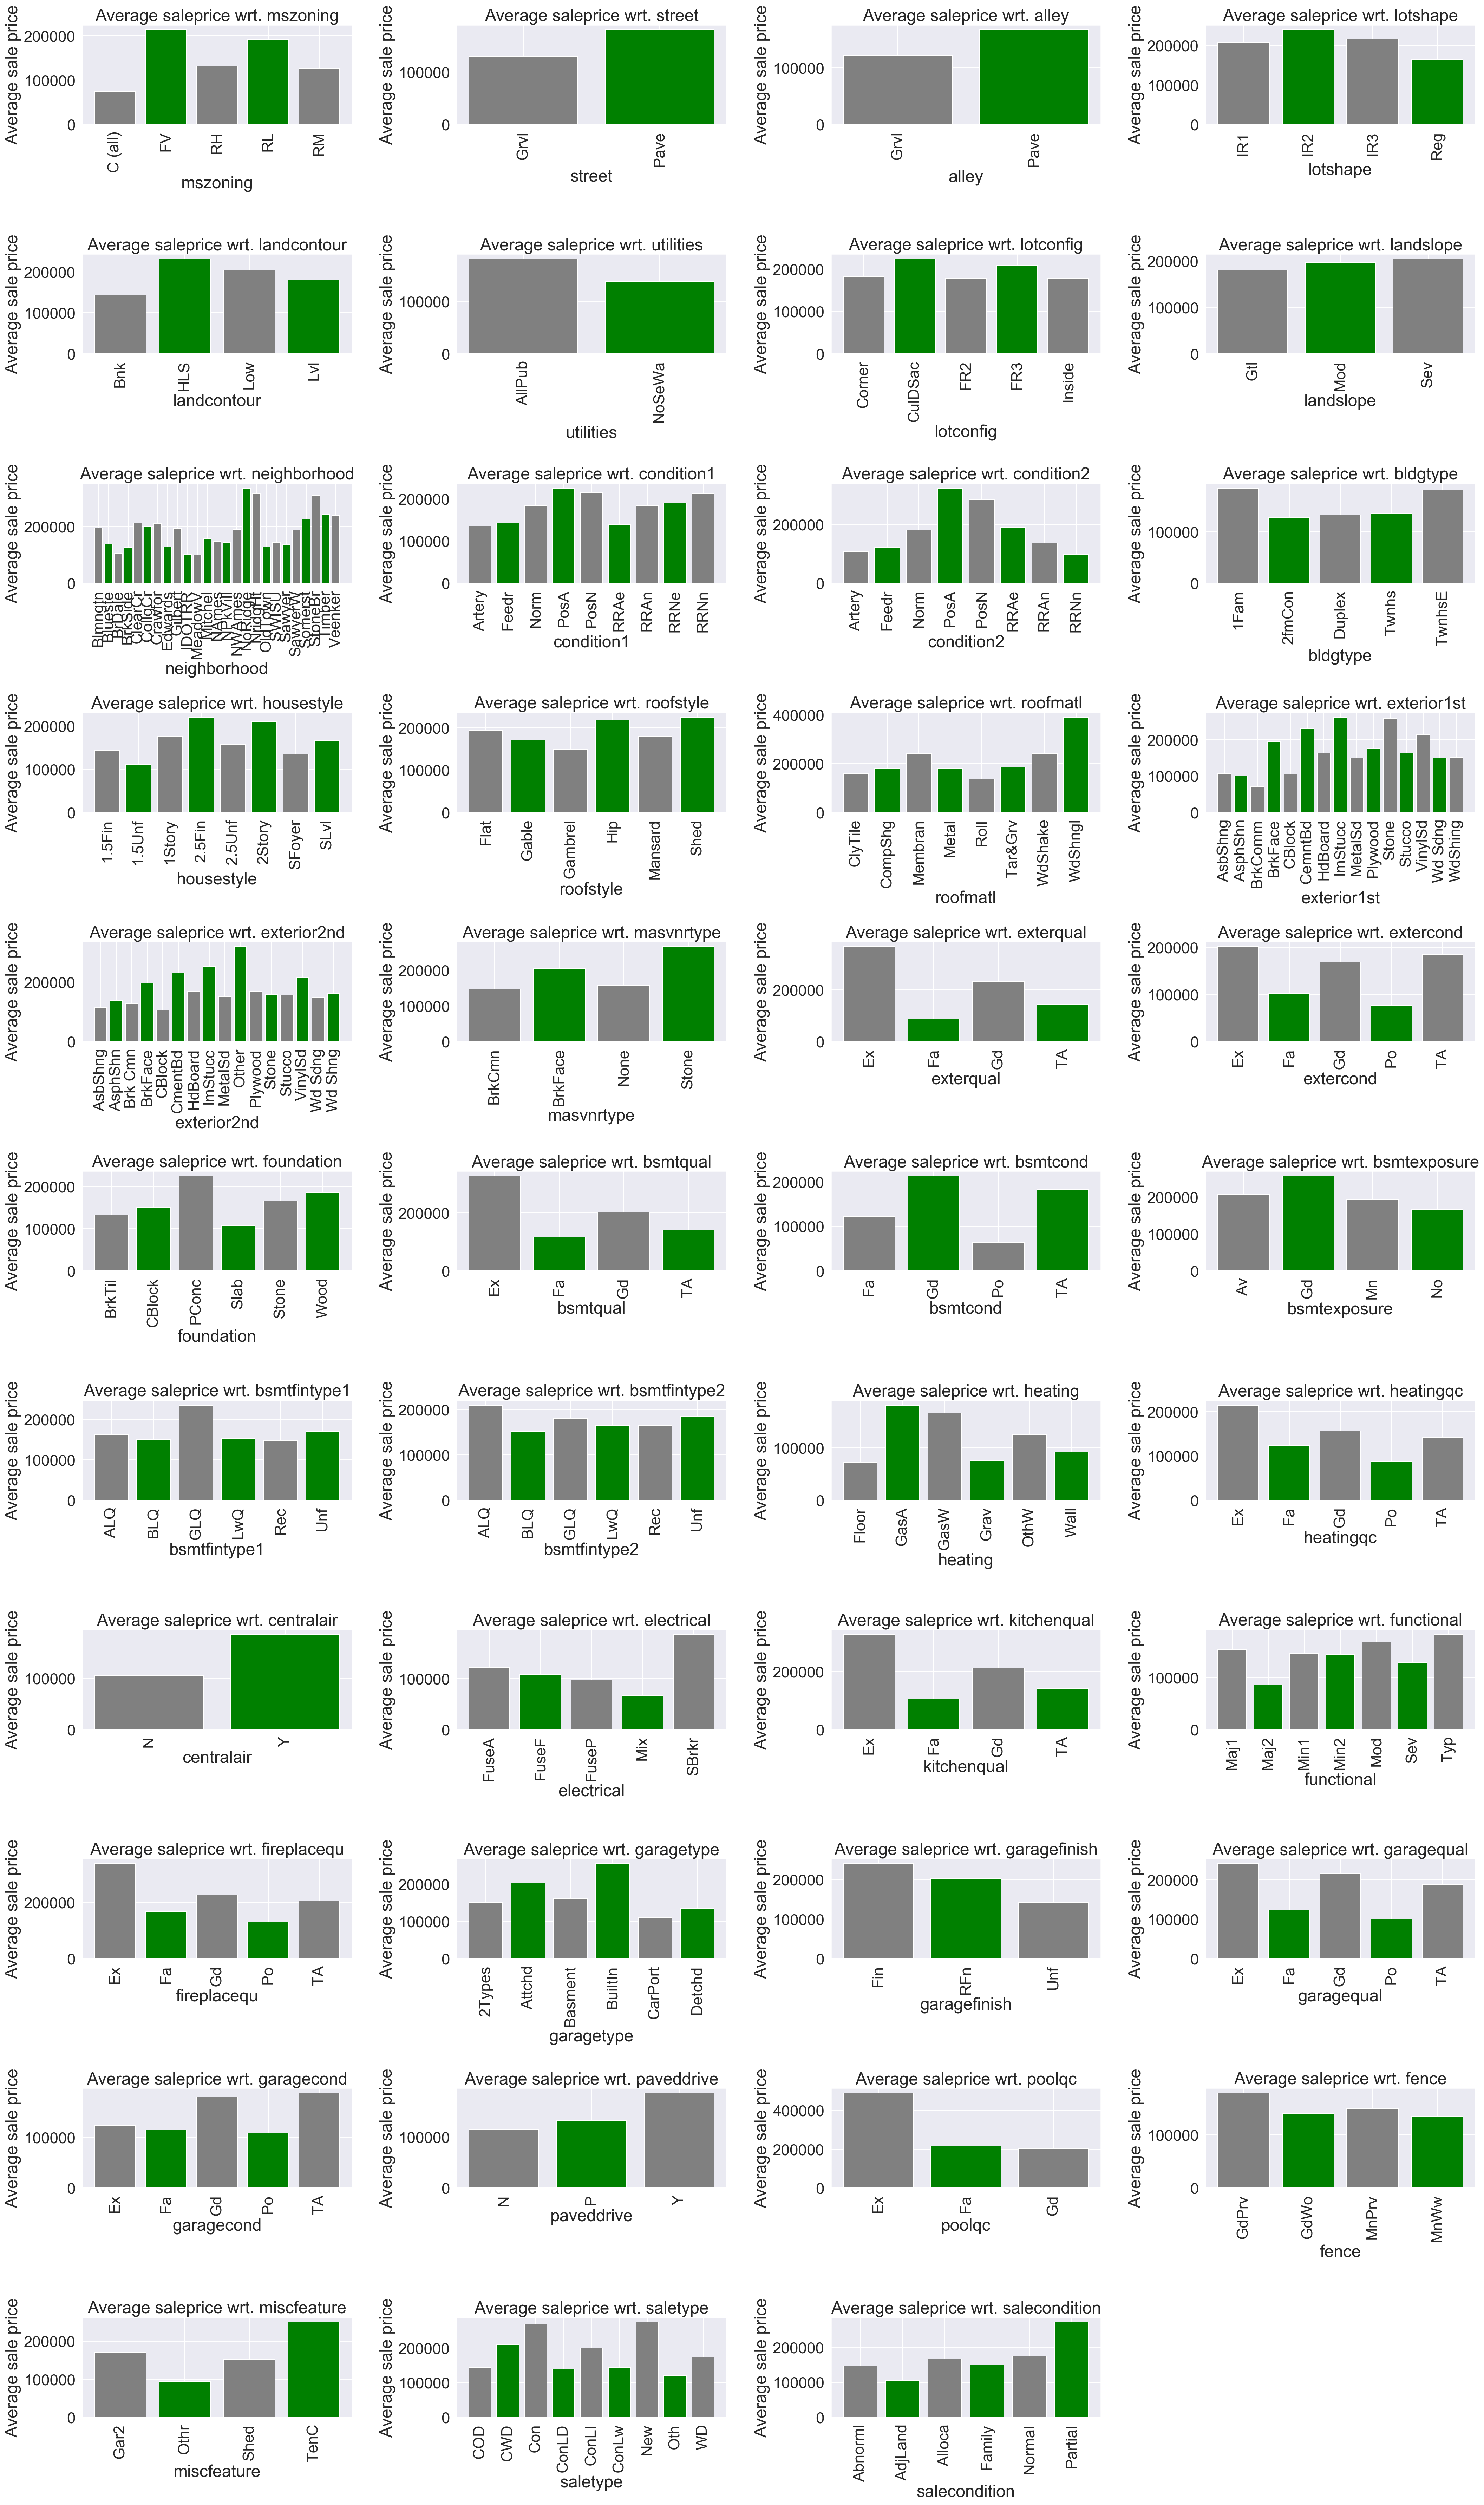

In [39]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(houseprices_df.groupby(column)["saleprice"].mean().index, houseprices_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

###### categorical values = 
'neighborhood', string values (20)
#this is probably important
'bsmtcond', string values (6)
'heatingqc', string values (5)
'centralair', string, yes/no
'kitchenqual', string values (5)
'paveddrive', string values (3)

In [9]:
houseprices_df['central_air_ohc'] = pd.get_dummies(houseprices_df.centralair, drop_first=True)

In [10]:
#creating OHC variables for mszoning
mszoning_ohc_df = pd.get_dummies(houseprices_df.mszoning, prefix = 'mszoning', drop_first=True)
mszoning_ohc_df.head()

,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [11]:
#creating OHC variables for kitchenqual
kitchenqual_ohc_df = pd.get_dummies(houseprices_df.kitchenqual, prefix = 'kitchenqual',drop_first=True)
kitchenqual_ohc_df.head()

,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0


In [12]:
#adding OHC variables to df
houseprices_df = pd.concat([houseprices_df, kitchenqual_ohc_df], axis=1)
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,miscval,mosold,yrsold,saletype,salecondition,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,1,0,1,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,1,0,0,1
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,1,0,1,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,1,0,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,1,0,1,0


In [13]:
#adding OHC variables to df
houseprices_df = pd.concat([houseprices_df, mszoning_ohc_df], axis=1)
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,salecondition,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,Normal,208500,1,0,1,0,0,0,1,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,Normal,181500,1,0,0,1,0,0,1,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,Normal,223500,1,0,1,0,0,0,1,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,Abnorml,140000,1,0,1,0,0,0,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,Normal,250000,1,0,1,0,0,0,1,0


In [14]:
#looking at only numeric values (incuding the OHC values)
numerics_df = houseprices_df.select_dtypes(include=[np.number])
numerics_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,yrsold,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,2008,208500,1,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,2007,181500,1,0,0,1,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,2008,223500,1,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,2006,140000,1,0,1,0,0,0,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,2008,250000,1,0,1,0,0,0,1,0


In [15]:
np.abs(numerics_df.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice          1.000000
overallqual        0.790982
grlivarea          0.708624
garagecars         0.640409
garagearea         0.623431
totalbsmtsf        0.613581
firstflrsf         0.605852
fullbath           0.560664
totrmsabvgrd       0.533723
yearbuilt          0.522897
kitchenqual_TA     0.519298
yearremodadd       0.507101
garageyrblt        0.486362
masvnrarea         0.477493
fireplaces         0.466929
bsmtfinsf1         0.386420
lotfrontage        0.351799
wooddecksf         0.324413
kitchenqual_Gd     0.321641
secondflrsf        0.319334
openporchsf        0.315856
mszoning_RM        0.288065
halfbath           0.284108
lotarea            0.263843
central_air_ohc    0.251328
mszoning_RL        0.245063
bsmtfullbath       0.227122
bsmtunfsf          0.214479
bedroomabvgr       0.168213
kitchenqual_Fa     0.157199
kitchenabvgr       0.135907
enclosedporch      0.128578
screenporch        0.111447
poolarea           0.092404
mszoning_FV        0.089950
mssubclass         0

Choosing only features with corr >0.5
overallqual        0.790982
grlivarea          0.708624
garagecars         0.640409
garagearea         0.623431
totalbsmtsf        0.613581
firstflrsf         0.605852
fullbath           0.560664
totrmsabvgrd       0.533723
yearbuilt          0.522897
TA                 0.519298
kitchenqual_TA     0.519298
yearremodadd       0.507101

In [16]:
features = ['overallqual', 'grlivarea', 'garagecars',
            'garagearea', 'totalbsmtsf', 'firstflrsf', 
            'fullbath', 'totrmsabvgrd', 'yearbuilt',
            'yearremodadd', 'kitchenqual_TA']

In [17]:
houseprices_df[features].isnull().sum()

overallqual       0
grlivarea         0
garagecars        0
garagearea        0
totalbsmtsf       0
firstflrsf        0
fullbath          0
totrmsabvgrd      0
yearbuilt         0
yearremodadd      0
kitchenqual_TA    0
dtype: int64

### fit model
Y = houseprices_df['saleprice']

X is the feature set: houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt',
'yearremodadd', 'kitchenqual_TA']]


In [18]:
# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set 
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars',
            'garagearea', 'totalbsmtsf', 'firstflrsf', 
            'fullbath', 'totrmsabvgrd', 'yearbuilt',
            'yearremodadd', 'kitchenqual_TA']]

# create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.87828228e+04  4.99680088e+01  1.04113769e+04  1.43382780e+01
  1.98410904e+01  1.43914025e+01 -7.47959886e+03  4.39276356e+02
  2.62300724e+02  2.18877628e+02 -9.03887736e+03]

Intercept: 
 -1010372.4726448985


In [19]:
#this is the same as above plus stats
import statsmodels.api as sm

# need to manually add a constant in statsmodels' sm
X_constant = sm.add_constant(X)

results = sm.OLS(Y, X_constant).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     454.8
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        07:47:24   Log-Likelihood:                -17453.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1448   BIC:                         3.499e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -1.01e+06   1.38e+05     -7.305      0.000   -1.28e+06   -7.39e+05
overallqual     1.878e+04   1209.243     15.533      0.000    1.64e+04    2.12e+04
grlivarea         49.9680      4.234     11.801      0.000      41.662      58.274
garagecars      1.041e+04   3032.818      3.433      0.001    4462.191    1.64e+04
garagearea        14.3383     10.274      1.396      0.163      -5.815      34.492
totalbsmtsf       19.8411      4.279      4.637      0.000      11.447      28.235
firstflrsf        14.3914      4.912      2.930      0.003       4.757      24.026
fullbath       -7479.5989   2679.682     -2.791      0.005   -1.27e+04   -2223.125
totrmsabvgrd     439.2764   1121.016      0.392      0.695   -1759.713    2638.266
yearbuilt        262.3007     50.186      5.227      0.000     163.855     360.746
yearremodadd     218.8776     67.247      3.255      0.001      86.965     350.790
kitchenqual_TA -9038.8774   2612.934     -3.459      0.001   -1.42e+04   -3913.337
==============================================================================
Omnibus:                      465.727   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58449.083
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                      33.989   Cond. No.                     5.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### check if your model meets the Gauss-Markov Conditions .
above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

#### Assumption one: linearity of the model in its coefficients

We can assume the linearity of the coefficients in the model as we use models that take into account this linearity assumption.

#### Assumption two: the error term should be zero on average

In [24]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

Mean of the errors in the weather model is: 6.450684613560977e-11


The error term appears to be approaching zero. 

#### Assumption three: homoscedasticity

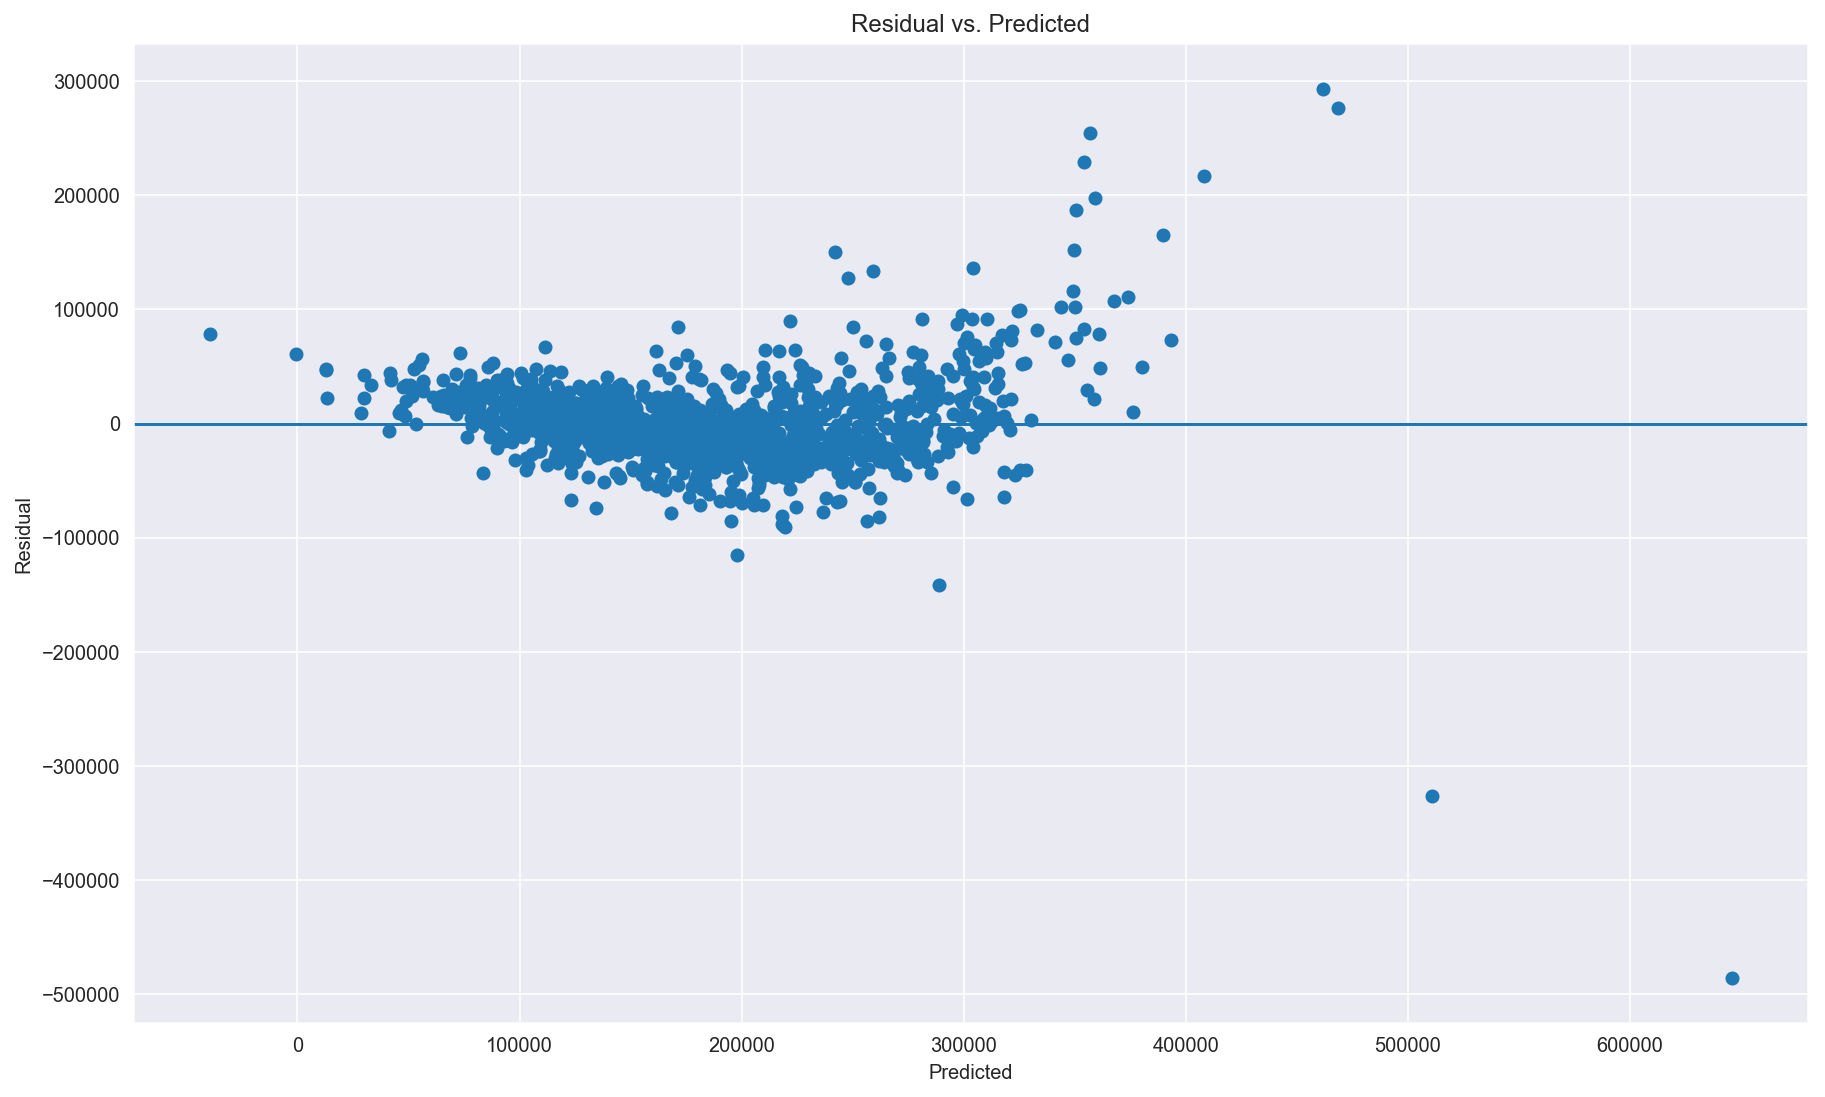

In [25]:
predictions = lrm.predict(X)
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [26]:
predictions = lrm.predict(X)
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 527.953 and p value is 7.87e-117
Levene test statistic value is 542.175 and p value is 3.86e-110


The null hypothesis for both tests is that the errors are homoscedastic.

The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

Possible causes for heteroscedasticity: outliers in the data, omitted variables that are important in explaining the variance of the target variable. Dealing with outliers and including relevant variables help to fix (transforming dependent variable [Box Cox or log transformation] & adding features that target the poorly-estimated areas).

#### Assumption four: low multicollinearity
From: https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
We can detect multicollinearity using the variance inflation factor (VIF). Without going into too many details, the interpretation of VIF is as follows: the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd,kitchenqual_TA
vif,2.858962,5.06042,5.250961,4.932462,3.602683,3.685331,2.227798,3.393748,2.348576,1.970315,1.745873


In [28]:
features_df = houseprices_df[['overallqual', 'grlivarea', 'garagecars',
            'garagearea', 'totalbsmtsf', 'firstflrsf', 
            'fullbath', 'totrmsabvgrd', 'yearbuilt',
            'yearremodadd', 'kitchenqual_TA']]

In [29]:
#or run corr of features only, not against target
np.abs(features_df.iloc[:,0:].corr())

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd,kitchenqual_TA
overallqual,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684,0.553891
grlivarea,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389,0.350179
garagecars,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622,0.399449
garagearea,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600,0.370935
totalbsmtsf,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066,0.311190
firstflrsf,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379,0.273566
fullbath,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046,0.418698
totrmsabvgrd,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740,0.210428
yearbuilt,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855,0.459792
yearremodadd,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.191740,0.592855,1.000000,0.576964


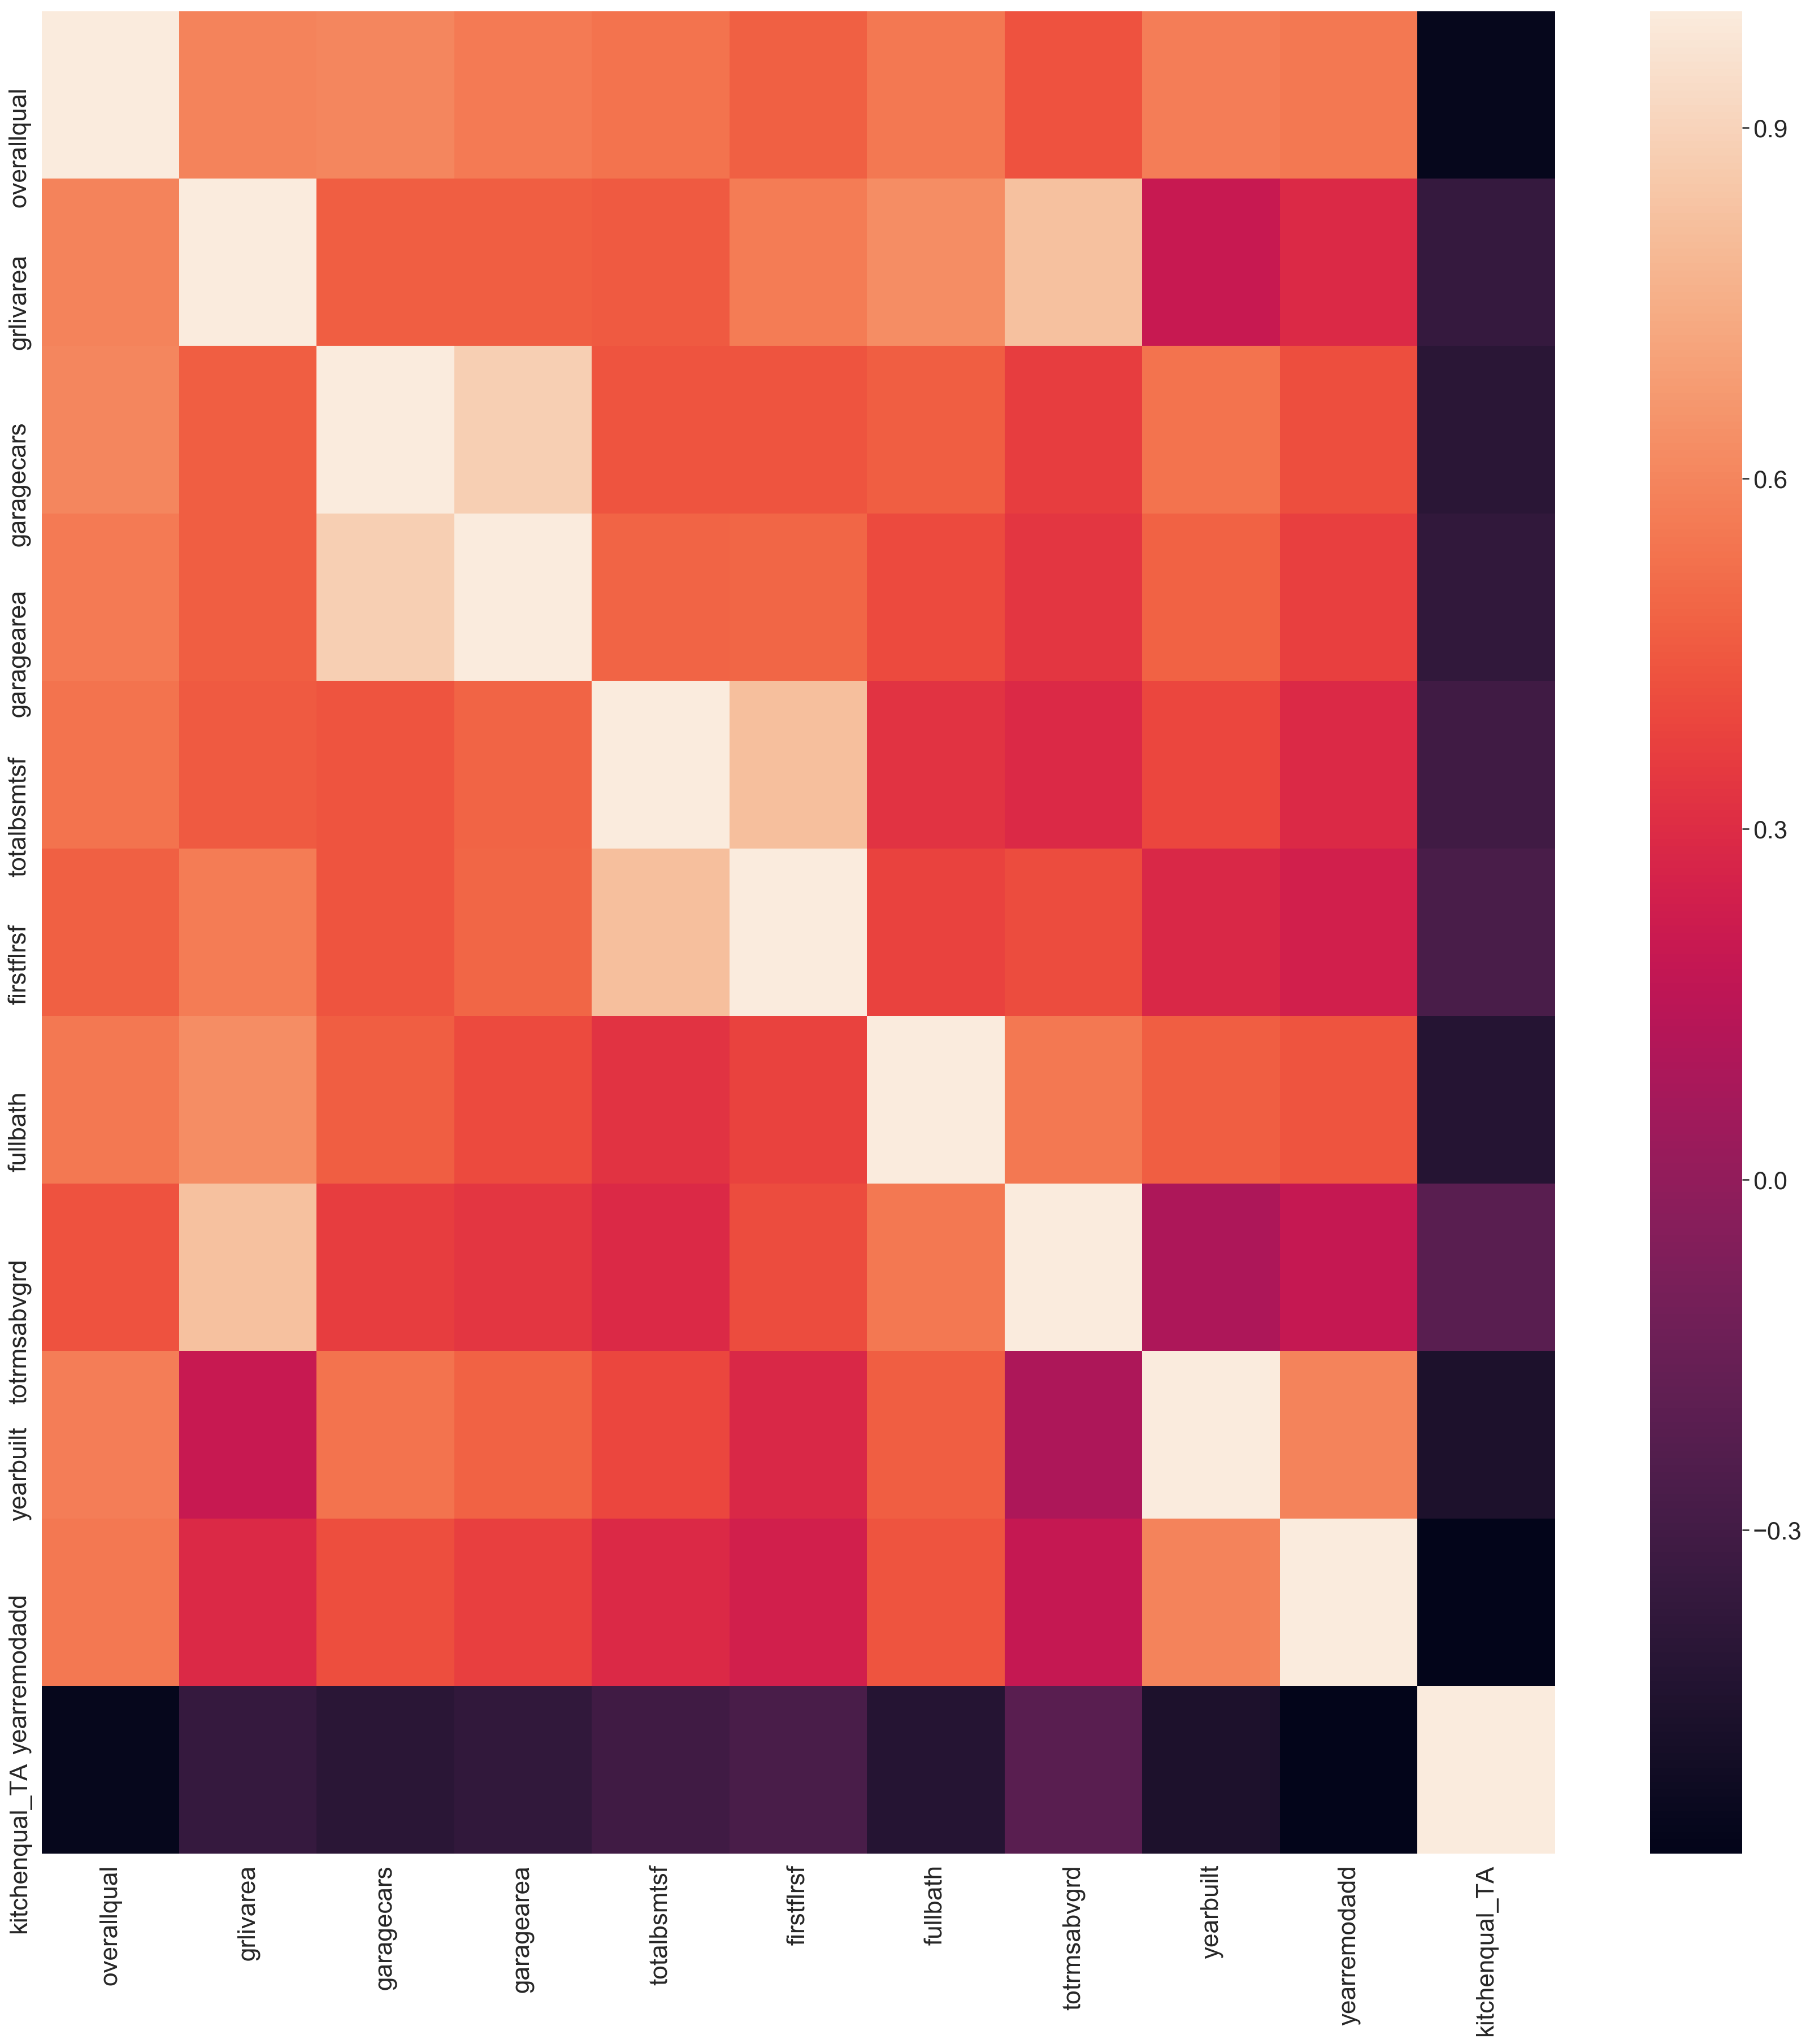

In [30]:
import seaborn as sns
plt.figure(figsize=(30,30))
sns.set(font_scale=2)
sns.heatmap(features_df.corr())

Clearly some of the features are correlated with each other, especially garagecars & garagearea, totalbsmtsf and firstflrsf, also totrmsabvgrd and grlivarea.

#### Assumption five: error terms should be uncorrelated with one another

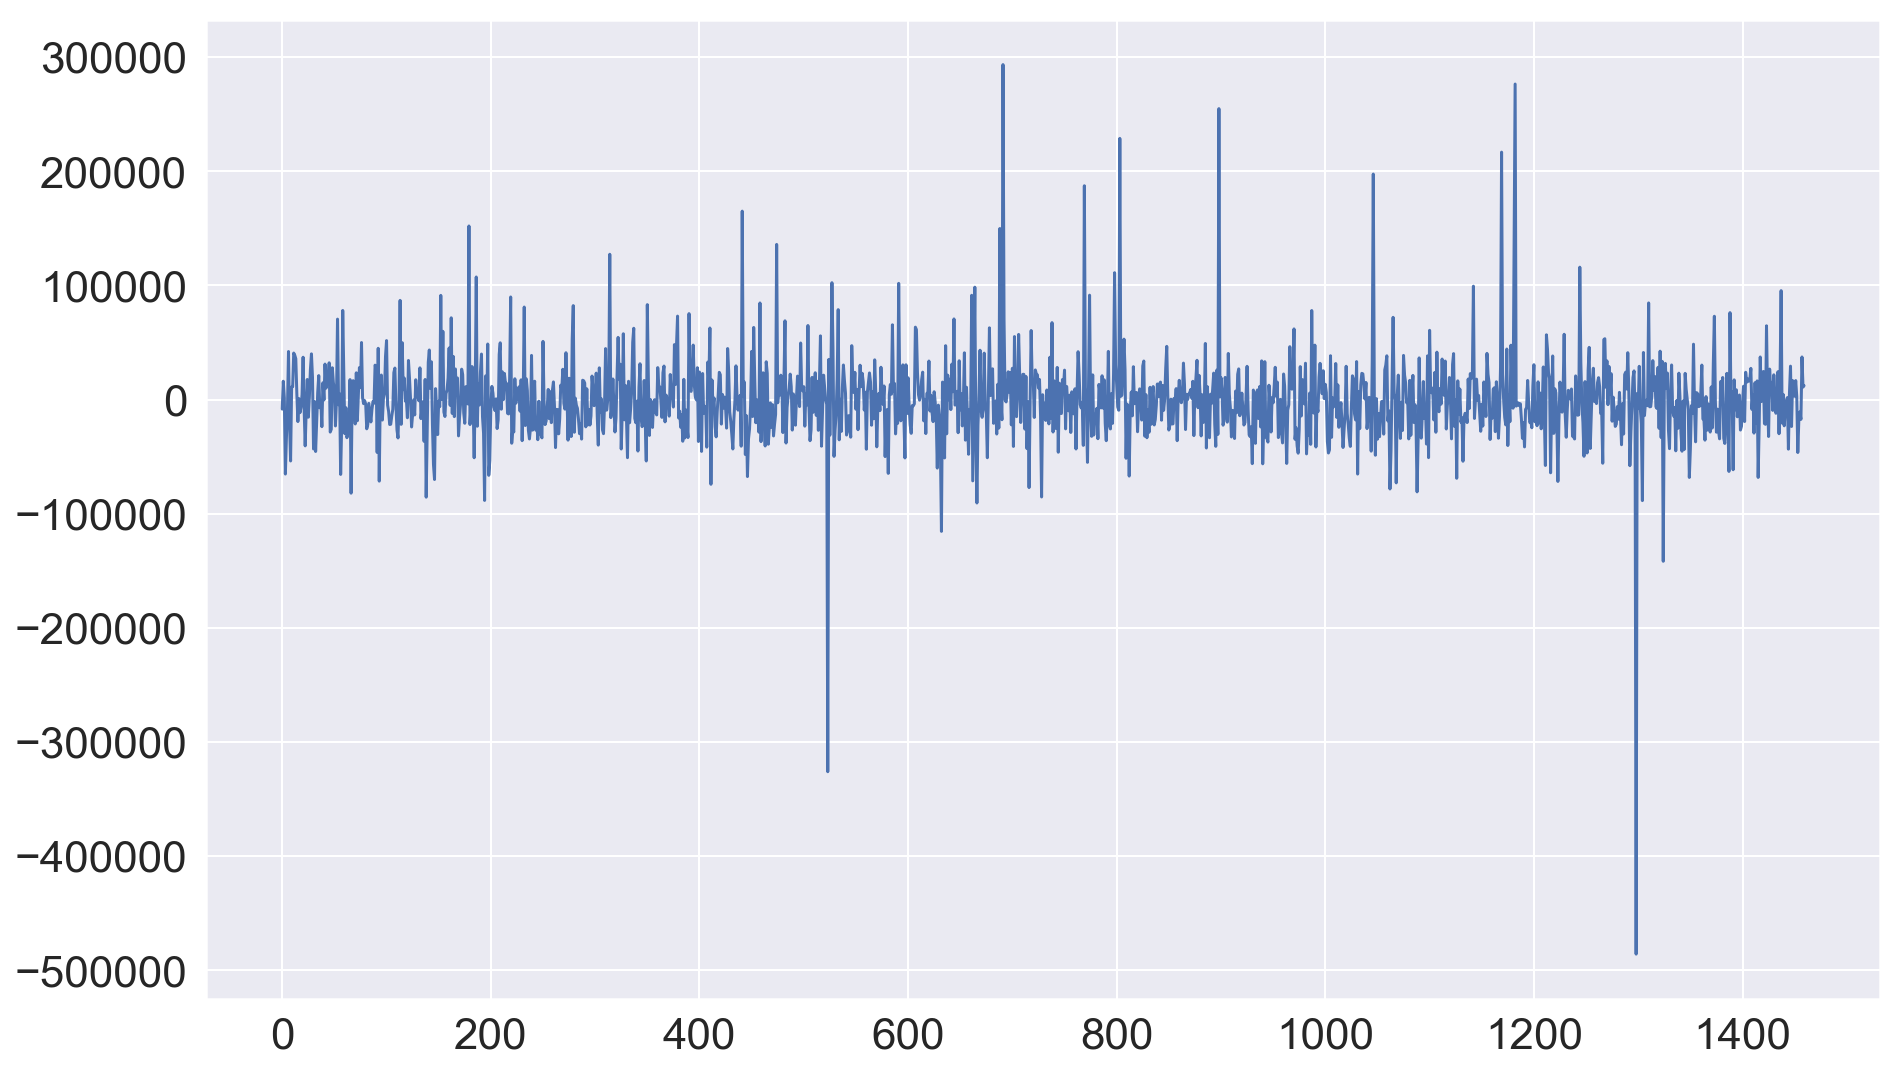

In [31]:
plt.plot(errors)
plt.show()

Errors appear to be uncorrelated.

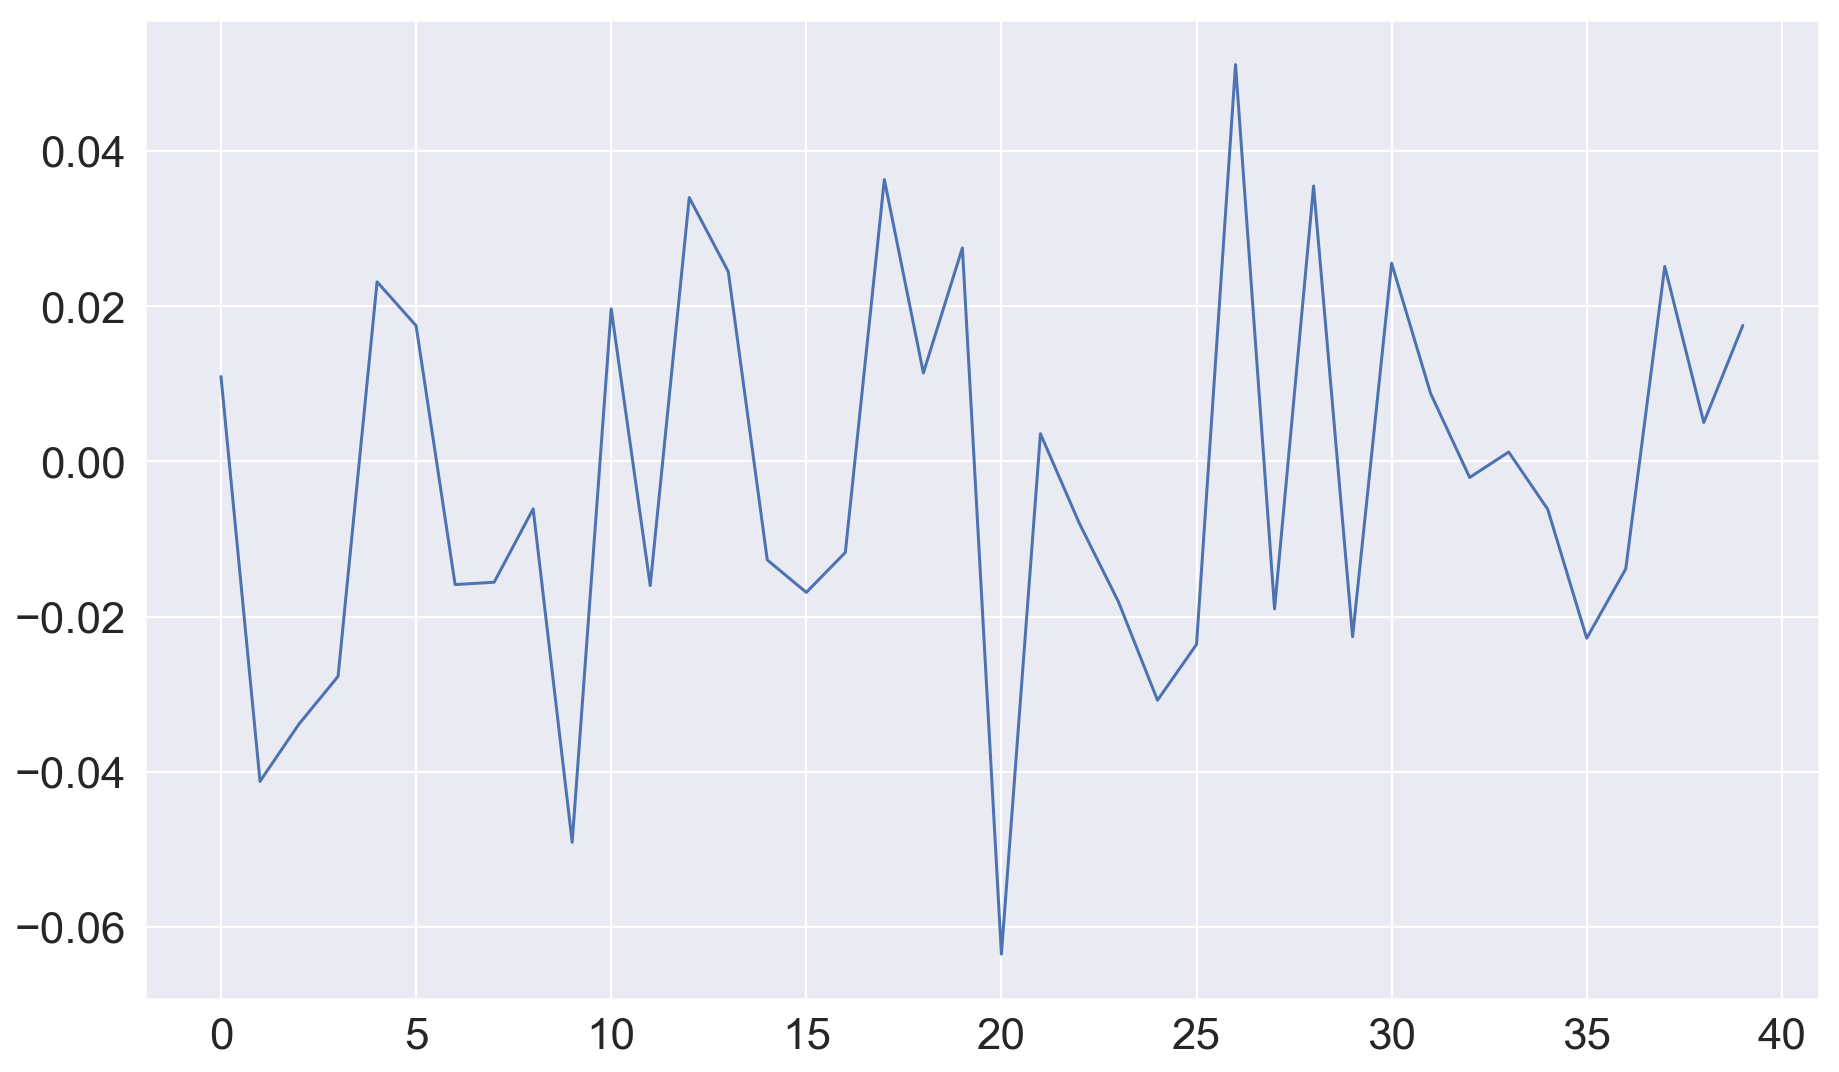

In [32]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Autocorrelation between errors appears to be low (ranging from -0.06 to 0.05).

#### Assumption six: features shouldn't be correlated with the errors

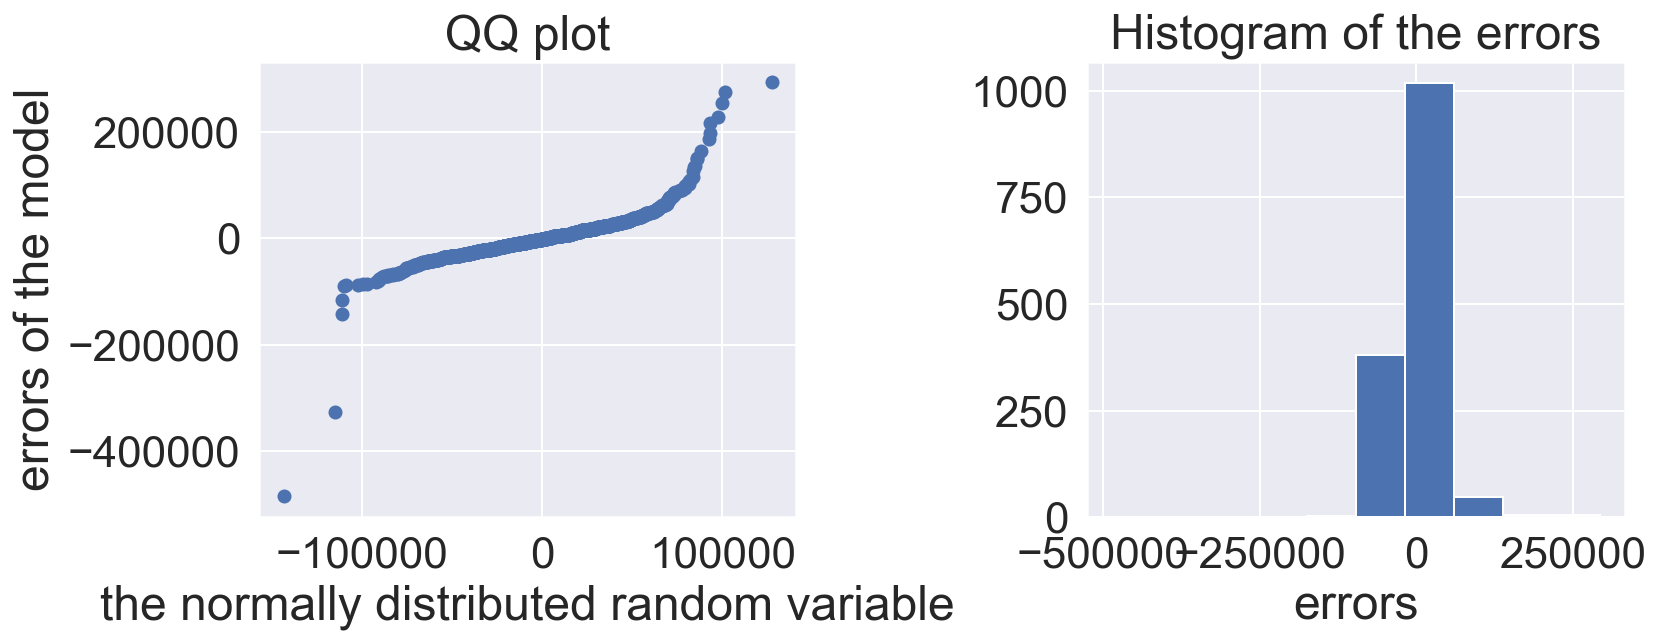

In [40]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel('the normally distributed random variable')
plt.ylabel('errors of the model')
plt.title('QQ plot')

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel('errors')
plt.title('Histogram of the errors')

plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [35]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 58449.083284555476 and p value is 0.0
Normality test statistics is 465.7271807656265 and p value is 7.38971451222121e-102


The null hypothesis of both tests is that the errors are normally distributed. The p-values of both tests indicate that our errors are not normally distributed.